In [31]:
import torch
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    HfArgumentParser, 
    TrainingArguments
)

from typing import Dict, Optional
from trl import DPOTrainer, DPOConfig

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load the dataset
The OpenAssistant Conversations (OASST1) dataset is a large-scale dataset for training AI assistants using Reinforcement Learning from Human Feedback (RLHF). It contains human-annotated conversations where different responses are ranked based on preference.

The dataset is structured into a JSON format containing:
- Messages: Conversations between a user and AI.
- Ranking Labels: Multiple AI responses are ranked based on human preference.
- Annotations: Contains additional metadata about responses.

In [3]:
def extract_anthropic_prompt(prompt_and_response):
    """Extract the anthropic prompt from a prompt and response pair."""
    search_term = "\n\nAssistant:"
    search_term_idx = prompt_and_response.rfind(search_term)
    assert search_term_idx != -1, f"Prompt and response does not contain '{search_term}'"
    return prompt_and_response[: search_term_idx + len(search_term)]

def get_hh(split) -> Dataset:

    dataset = load_dataset("Anthropic/hh-rlhf", split=split, cache_dir=None)
    dataset = dataset.select(range(min(len(dataset), 1000)))

    def split_prompt_and_responses(sample) -> Dict[str, str]:
        prompt = extract_anthropic_prompt(sample["chosen"])
        return {
            "prompt": prompt,
            "chosen": sample["chosen"][len(prompt) :],
            "rejected": sample["rejected"][len(prompt) :],
        }

    return dataset.map(split_prompt_and_responses)

In [4]:
train_dataset = get_hh("train")
eval_dataset = get_hh("test")

In [5]:
train_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 1000
})

# Load a pretrained model and tokenizer

In [6]:
model_name_or_path = "gpt2"
ignore_bias_buffers = False

model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
if ignore_bias_buffers:
    # torch distributed hack
    model._ddp_params_and_buffers_to_ignore = [
        name for name, buffer in model.named_buffers() if buffer.dtype == torch.bool
    ]

model_ref = AutoModelForCausalLM.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

## Initialize training args

In [7]:
training_args = DPOConfig(
		num_train_epochs=3,
		learning_rate=5e-07,
		per_device_train_batch_size=1,
		do_eval=True,
		per_device_eval_batch_size=1,
		adam_epsilon=1e-08,
		lr_scheduler_type="linear",
		warmup_ratio=0.1,
		seed=42,
		logging_steps=100,
		save_steps=500,
		save_strategy="steps",
		output_dir="./output-dir",
		gradient_checkpointing=True,
		bf16=True,
		remove_unused_columns=False,
	)

In [8]:
dpo_trainer = DPOTrainer(
		model,
		model_ref,
		args=training_args,
		train_dataset=train_dataset,
		eval_dataset=eval_dataset,
		processing_class=tokenizer,
	)

In [9]:
dpo_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
100,0.694400
200,0.690900
300,0.666000
400,0.692200
500,0.668300
600,0.640800
700,0.694700
800,0.637700
900,0.710800
1000,0.674300


TrainOutput(global_step=3000, training_loss=0.6140020802815755, metrics={'train_runtime': 1510.5173, 'train_samples_per_second': 1.986, 'train_steps_per_second': 1.986, 'total_flos': 0.0, 'train_loss': 0.6140020802815755, 'epoch': 3.0})

In [13]:
dpo_trainer.save_model("model-save")

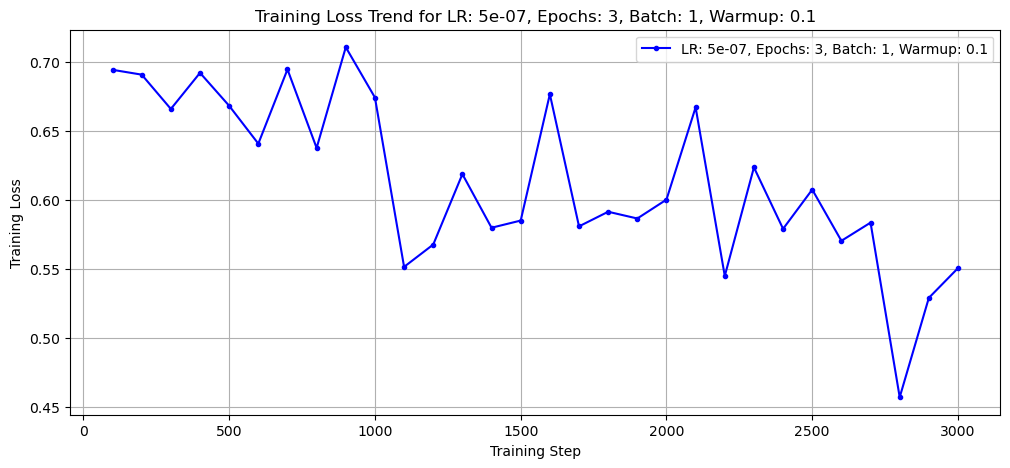

In [19]:
# Create DataFrame from the provided data
data_model = pd.DataFrame({
    "Learning Rate": [5e-07] * 30,
    "Num Epochs": [3] * 30,
    "Batch Size": [1] * 30,
    "Warmup Ratio": [0.1] * 30,
    "Training Loss": [0.694400, 0.690900, 0.666000, 0.692200, 0.668300, 0.640800, 0.694700,
                      0.637700, 0.710800, 0.674300, 0.551400, 0.567600, 0.618700, 0.579800,
                      0.585000, 0.676700, 0.580800, 0.591400, 0.586500, 0.600200, 0.667200,
                      0.544800, 0.623600, 0.579000, 0.607500, 0.570300, 0.583500, 0.456800,
                      0.528900, 0.550500],
    "Step": list(range(100, 3100, 100))
})

# Plot training loss for this configuration
plt.figure(figsize=(12, 5))
plt.plot(data_model["Step"], data_model["Training Loss"], marker='.', linestyle='-', color='b', label="LR: 5e-07, Epochs: 3, Batch: 1, Warmup: 0.1")

plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Trend for LR: 5e-07, Epochs: 3, Batch: 1, Warmup: 0.1")
plt.legend()
plt.grid(True)
plt.show()


## Playing around with hyperparameters


In [19]:
lrs=[1e-01, 1e-03, 1e-05]
num_train_epochs=[1, 3]
per_device_train_batch_sizes=[1, 2]
warmup_ratios=[0.1, 0.2]

In [20]:
for lr in lrs:
    for num_train_epoch in num_train_epochs:
        for per_device_train_batch_size in per_device_train_batch_sizes:
            for warmup_ratio in warmup_ratios:
                training_args = DPOConfig(
                    num_train_epochs=num_train_epoch,
                    learning_rate=lr,
                    per_device_train_batch_size=per_device_train_batch_size,
                    do_eval=True,
                    per_device_eval_batch_size=per_device_train_batch_size,
                    adam_epsilon=1e-08,
                    lr_scheduler_type="linear",
                    warmup_ratio=warmup_ratio,
                    seed=42,
                    logging_steps=100,
                    save_steps=500,
                    save_strategy="steps",
                    output_dir=f"./output-dir-lr-{lr}-epochs-{num_train_epoch}-batch-{per_device_train_batch_size}-warmup-{warmup_ratio}",
                    gradient_checkpointing=True,
                    bf16=True,
                    remove_unused_columns=False,
                )

                dpo_trainer_2 = DPOTrainer(
                    model,
                    model_ref,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=eval_dataset,
                    processing_class=tokenizer,
                )
                print(f'lr:{lr} num_epochs:{num_train_epoch} batch_size:{per_device_train_batch_size} warmup_ratio:{warmup_ratio}')
                dpo_trainer_2.train()

lr:0.1 num_epochs:1 batch_size:1 warmup_ratio:0.1


Step,Training Loss
100,109.659900
200,124.108200
300,132.351900
400,86.796200
500,61.801000
600,61.874600
700,35.817900
800,24.399700
900,15.742300
1000,8.769000


lr:0.1 num_epochs:1 batch_size:1 warmup_ratio:0.2


Step,Training Loss
100,43.025100
200,191.695200
300,291.311200
400,238.407600
500,135.442000
600,159.696800
700,84.970700
800,56.780800
900,56.464200
1000,22.735900


lr:0.1 num_epochs:1 batch_size:2 warmup_ratio:0.1


Step,Training Loss
100,136.033200
200,287.812800
300,119.652400
400,64.482000
500,30.362000


lr:0.1 num_epochs:1 batch_size:2 warmup_ratio:0.2


Step,Training Loss
100,89.100700
200,399.118600
300,186.523400
400,119.801800
500,53.040800


lr:0.1 num_epochs:3 batch_size:1 warmup_ratio:0.1


Step,Training Loss
100,72.328700
200,117.934900
300,313.671000
400,458.822700
500,310.002000
600,383.641100
700,330.961700
800,331.813700
900,327.704000
1000,281.829700


lr:0.1 num_epochs:3 batch_size:1 warmup_ratio:0.2


Step,Training Loss
100,28.655300
200,31.579600
300,94.475700
400,288.708300
500,289.615000
600,526.257700
700,426.069300
800,492.452500
900,542.353600
1000,448.486200


lr:0.1 num_epochs:3 batch_size:2 warmup_ratio:0.1


Step,Training Loss
100,63.498500
200,370.612900
300,453.865400
400,605.380800
500,421.741000
600,228.986500
700,284.988900
800,210.390300
900,179.816000
1000,162.794600


lr:0.1 num_epochs:3 batch_size:2 warmup_ratio:0.2


Step,Training Loss
100,47.706300
200,147.958000
300,239.775700
400,465.320000
500,583.182700
600,357.635800
700,397.815200
800,224.544800
900,255.885400
1000,219.886800


lr:0.001 num_epochs:1 batch_size:1 warmup_ratio:0.1


Step,Training Loss
100,82.461300
200,26.683600
300,19.364700
400,32.642500
500,10.711900
600,18.103300
700,23.604400
800,24.797200
900,19.862600
1000,31.554700


lr:0.001 num_epochs:1 batch_size:1 warmup_ratio:0.2


Step,Training Loss
100,69.713600
200,22.237100
300,15.350900
400,29.071100
500,9.908300
600,16.362400
700,20.316200
800,22.099800
900,19.322000
1000,30.439500


lr:0.001 num_epochs:1 batch_size:2 warmup_ratio:0.1


Step,Training Loss
100,41.754000
200,19.718700
300,11.517600
400,18.828600
500,22.641700


lr:0.001 num_epochs:1 batch_size:2 warmup_ratio:0.2


Step,Training Loss
100,37.764000
200,18.019000
300,10.820500
400,17.448600
500,21.542200


lr:0.001 num_epochs:3 batch_size:1 warmup_ratio:0.1


Step,Training Loss
100,54.378900
200,16.162200
300,10.432800
400,22.229000
500,8.013800
600,16.092600
700,16.497400
800,18.240900
900,18.889000
1000,24.997000


lr:0.001 num_epochs:3 batch_size:1 warmup_ratio:0.2


Step,Training Loss
100,40.950700
200,12.438500
300,5.643700
400,18.008500
500,6.190800
600,11.978400
700,12.455000
800,15.294800
900,16.815400
1000,18.859900


lr:0.001 num_epochs:3 batch_size:2 warmup_ratio:0.1


Step,Training Loss
100,21.559900
200,9.868200
300,7.338700
400,10.868900
500,13.478700
600,7.778500
700,11.572900
800,10.443300
900,10.103200
1000,14.866400


lr:0.001 num_epochs:3 batch_size:2 warmup_ratio:0.2


Step,Training Loss
100,18.567500
200,7.604300
300,6.158700
400,9.398100
500,12.213400
600,6.250700
700,10.175700
800,9.965600
900,9.099800
1000,12.918300


lr:1e-05 num_epochs:1 batch_size:1 warmup_ratio:0.1


Step,Training Loss
100,24.825500
200,7.512600
300,1.710900
400,10.597300
500,3.614300
600,5.409900
700,5.756000
800,6.143100
900,6.424600
1000,8.278000


lr:1e-05 num_epochs:1 batch_size:1 warmup_ratio:0.2


Step,Training Loss
100,24.768400
200,7.478900
300,1.696000
400,10.569100
500,3.606100
600,5.407600
700,5.742800
800,6.122700
900,6.426300
1000,8.285900


lr:1e-05 num_epochs:1 batch_size:2 warmup_ratio:0.1


Step,Training Loss
100,16.111800
200,6.111700
300,4.490900
400,5.905400
500,7.350300


lr:1e-05 num_epochs:1 batch_size:2 warmup_ratio:0.2


Step,Training Loss
100,16.087300
200,6.104400
300,4.489700
400,5.894700
500,7.356700


lr:1e-05 num_epochs:3 batch_size:1 warmup_ratio:0.1


Step,Training Loss
100,24.697100
200,7.464800
300,1.699700
400,10.486600
500,3.578900
600,5.376600
700,5.673800
800,6.078200
900,6.402800
1000,8.310800


lr:1e-05 num_epochs:3 batch_size:1 warmup_ratio:0.2


Step,Training Loss
100,24.610900
200,7.420700
300,1.710000
400,10.503800
500,3.565700
600,5.347500
700,5.623700
800,6.029700
900,6.368800
1000,8.252300


lr:1e-05 num_epochs:3 batch_size:2 warmup_ratio:0.1


Step,Training Loss
100,15.981700
200,6.096300
300,4.443900
400,5.805000
500,7.276400
600,4.730300
700,8.559500
800,7.812000
900,7.262700
1000,11.158200


lr:1e-05 num_epochs:3 batch_size:2 warmup_ratio:0.2


Step,Training Loss
100,15.963000
200,6.073300
300,4.427300
400,5.766200
500,7.261400
600,4.705000
700,8.557300
800,7.808800
900,7.237300
1000,11.135200


## Training Losses

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the training data
data = [
    (0.1, 1, 1, 0.1, [109.66, 124.11, 132.35, 86.79, 61.80, 61.87, 35.81, 24.39, 15.74, 8.76]),
    (0.1, 1, 1, 0.2, [43.02, 191.69, 291.31, 238.40, 135.44, 159.69, 84.97, 56.78, 56.46, 22.73]),
    (0.1, 1, 2, 0.1, [136.03, 287.81, 119.65, 64.48, 30.36]),
    (0.1, 1, 2, 0.2, [89.10, 399.11, 186.52, 119.80, 53.04]),
    (0.1, 3, 1, 0.1, [72.32, 117.93, 313.67, 458.82, 310.00, 383.64, 330.96, 331.81, 327.70, 281.82]),
    (0.1, 3, 1, 0.2, [28.65, 31.57, 94.47, 288.70, 289.61, 526.25, 426.06, 492.45, 542.35, 448.48]),
    (0.1, 3, 2, 0.1, [63.49, 370.61, 453.86, 605.38, 421.74, 228.98, 284.98, 210.39, 179.81, 162.79]),
    (0.1, 3, 2, 0.2, [47.70, 147.95, 239.77, 465.32, 583.18, 357.63, 397.81, 224.54, 255.88, 219.88]),
    (0.001, 1, 1, 0.1, [82.46, 26.68, 19.36, 32.64, 10.71, 18.10, 23.60, 24.79, 19.86, 31.55]),
    (0.001, 1, 1, 0.2, [69.71, 22.23, 15.35, 29.07, 9.90, 16.36, 20.31, 22.09, 19.32, 30.43]),
    (0.001, 1, 2, 0.1, [41.75, 19.71, 11.51, 18.82, 22.64]),
    (0.001, 1, 2, 0.2, [37.76, 18.01, 10.82, 17.44, 21.54]),
    (0.001, 3, 1, 0.1, [54.37, 16.16, 10.43, 22.22, 8.01, 16.09, 16.49, 18.24, 18.88, 24.99]),
    (0.001, 3, 1, 0.2, [40.95, 12.43, 5.64, 18.00, 6.19, 11.97, 12.45, 15.29, 16.81, 18.85]),
    (0.001, 3, 2, 0.1, [21.55, 9.86, 7.33, 10.86, 13.47, 7.77, 11.57, 10.44, 10.10, 14.86]),
    (0.001, 3, 2, 0.2, [18.56, 7.60, 6.15, 9.39, 12.21, 6.25, 10.17, 9.96, 9.09, 12.91]),
    (1e-5, 1, 1, 0.1, [24.82, 7.51, 1.71, 10.59, 3.61, 5.40, 5.75, 6.14, 6.42, 8.27]),
    (1e-5, 1, 1, 0.2, [24.76, 7.47, 1.69, 10.56, 3.60, 5.40, 5.74, 6.12, 6.42, 8.28]),
    (1e-5, 1, 2, 0.1, [16.11, 6.11, 4.49, 5.90, 7.35]),
    (1e-5, 1, 2, 0.2, [16.08, 6.10, 4.48, 5.89, 7.35]),
    (1e-5, 3, 1, 0.1, [24.69, 7.46, 1.69, 10.48, 3.57, 5.37, 5.67, 6.07, 6.40, 8.31]),
    (1e-5, 3, 1, 0.2, [24.61, 7.42, 1.71, 10.50, 3.56, 5.34, 5.62, 6.02, 6.36, 8.25]),
]

# Create a dataframe
df = pd.DataFrame(data, columns=["Learning Rate", "Num Epochs", "Batch Size", "Warmup Ratio", "Training Loss"])

# Expand training loss values into separate columns
df_expanded = df.explode("Training Loss")

# Convert step index
df_expanded["Step"] = df_expanded.groupby(["Learning Rate", "Num Epochs", "Batch Size", "Warmup Ratio"]).cumcount() + 1



In [29]:
df_expanded

,Learning Rate,Num Epochs,Batch Size,Warmup Ratio,Training Loss,Step
0,0.10000,1,1,0.1,109.66,1
0,0.10000,1,1,0.1,124.11,2
0,0.10000,1,1,0.1,132.35,3
0,0.10000,1,1,0.1,86.79,4
0,0.10000,1,1,0.1,61.8,5
...,...,...,...,...,...,...
21,0.00001,3,1,0.2,5.34,6
21,0.00001,3,1,0.2,5.62,7
21,0.00001,3,1,0.2,6.02,8
21,0.00001,3,1,0.2,6.36,9


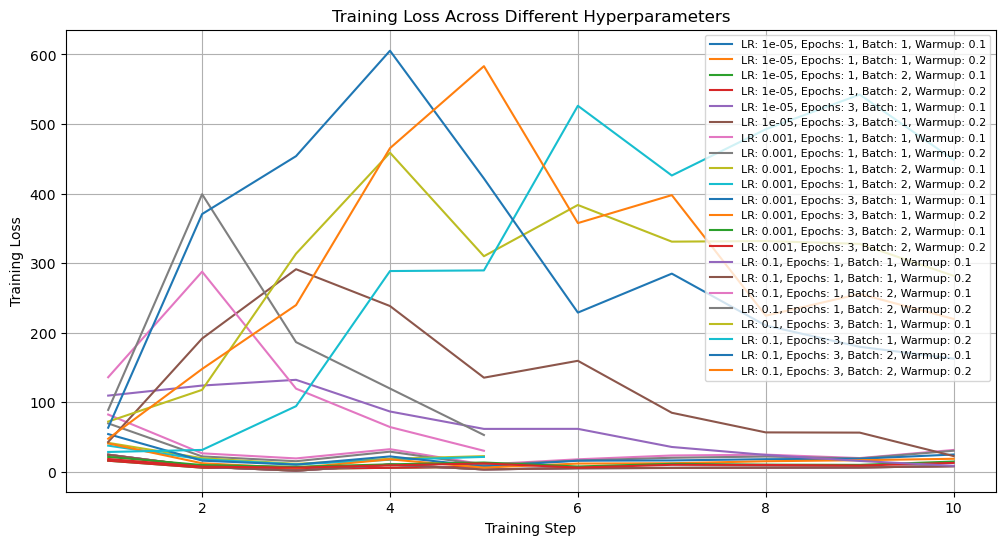

In [30]:
# Plot training loss trends
plt.figure(figsize=(12, 6))
for key, group in df_expanded.groupby(["Learning Rate", "Num Epochs", "Batch Size", "Warmup Ratio"]):
    plt.plot(group["Step"], group["Training Loss"], label=f"LR: {key[0]}, Epochs: {key[1]}, Batch: {key[2]}, Warmup: {key[3]}")

plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Across Different Hyperparameters")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True)
plt.show()


## Graph visualization including the very first DPO TRAINING 
with the following parameters
- lr = 5e-07
- num_epochs = 3
- warmup_ratio= 0.1
- batch_size = 1

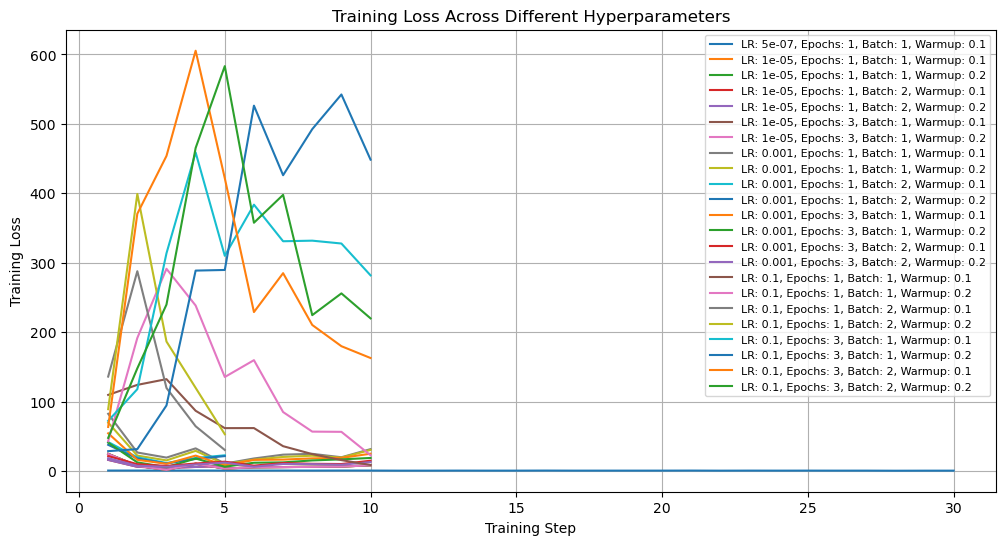

In [ ]:
# Add the new data (for the very first dpo training) to the existing dataframe
data.append((5e-7, 1, 1, 0.1, [0.694400, 0.690900, 0.666000, 0.692200, 0.668300, 0.640800, 0.694700,
                      0.637700, 0.710800, 0.674300, 0.551400, 0.567600, 0.618700, 0.579800,
                      0.585000, 0.676700, 0.580800, 0.591400, 0.586500, 0.600200, 0.667200,
                      0.544800, 0.623600, 0.579000, 0.607500, 0.570300, 0.583500, 0.456800,
                      0.528900, 0.550500]))

# Create a dataframe
df = pd.DataFrame(data, columns=["Learning Rate", "Num Epochs", "Batch Size", "Warmup Ratio", "Training Loss"])

# Expand training loss values into separate columns
df_expanded = df.explode("Training Loss")

# Convert step index
df_expanded["Step"] = df_expanded.groupby(["Learning Rate", "Num Epochs", "Batch Size", "Warmup Ratio"]).cumcount() + 1

# Plot training loss trends
plt.figure(figsize=(12, 6))
for key, group in df_expanded.groupby(["Learning Rate", "Num Epochs", "Batch Size", "Warmup Ratio"]):
    plt.plot(group["Step"], group["Training Loss"], label=f"LR: {key[0]}, Epochs: {key[1]}, Batch: {key[2]}, Warmup: {key[3]}")

plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Across Different Hyperparameters")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True)
plt.show()

### Inference

- High Learning Rate (0.1) Causes Instability
    - Sharp fluctuations in training loss, especially in the early steps.
    - Some runs diverge (loss increases instead of decreasing).
    - Loss starts extremely high (300-600 range), indicating instability.
    - Possible issue can be that the model is taking too large steps during optimization, overshooting the optimal region.

- Lower Learning Rates (0.001, 1e-5, 5e-7) Improve Stability
    - Learning rates 0.001, 1e-5, and 5e-7 show smoother, more stable loss curves.
    - Loss starts lower (10-100 range) and decreases gradually.
    - No major spikes or divergence.
    - Final loss is lower, indicating better convergence.

- Higher warmup ratio (0.2) results in a delayed decrease in loss while a lower warmup ratio (0.1) leads to faster initial loss reduction

- More Epochs Improve Long-Term Loss Reduction

- Larger batch sizes reduce variance in gradient updates

# Testing model 

- The model is uploaded to huggingface
- huggingface model : Suryansh-bit/a5-dpo-st124997
- link : https://huggingface.co/Suryansh-bit/a5-dpo-st124997/tree/main

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
model_name = "Suryansh-bit/a5-dpo-st124997"  

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

In [34]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [35]:
input_text = "Once upon a time"

# Tokenize input
inputs = tokenizer(input_text, return_tensors="pt").to(device)

with torch.no_grad():
    output = model.generate(**inputs, max_length=100)

# Decode and print output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world was a place of great danger. The world
